In [54]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import matplotlib.pyplot as plt 
import scipy.integrate as spint

import scipy.optimize as spopt
import numpy as np
import tqdm.notebook
from jax import config
config.update('jax_enable_x64', True)

## Generate data from integration of the following ODE system

$$
\begin{cases}
\dot{y}_1 = y_2 \\
\dot{y}_2 = -y_1 (1 + y_3^2) \\
\dot{y}_3 = y_4 \\
\dot{y}_4 = -y_3 (1 + y_1^2) \\
\end{cases}
$$
with starting point $y(0) = [1, 0, \xi_{3}, \xi_4]$, where $\xi_{3,4} \sim \mathcal{N}(0, \sigma^2)$

In [2]:
def rhs(x, t):
    return jnp.array([x[1], -x[0] * (1 + x[2]**2), x[3], -x[2] * (1 + x[0]**2)])

# Noise for modeling the hidden part of the dynamics
sigma = 1
x0 = jnp.hstack((jnp.array([1, 0]), sigma * jax.random.normal(jax.random.PRNGKey(1), (2,))))
print(x0)

[ 1.          0.          0.17269028 -0.46084179]


In [4]:
delta_t = 1e-1
final_T = 50
num_T = 500
t_range = jnp.linspace(0, final_T, num=num_T+1)
traj = spint.odeint(rhs, x0, t_range)

Text(0, 0.5, '$y_1$')

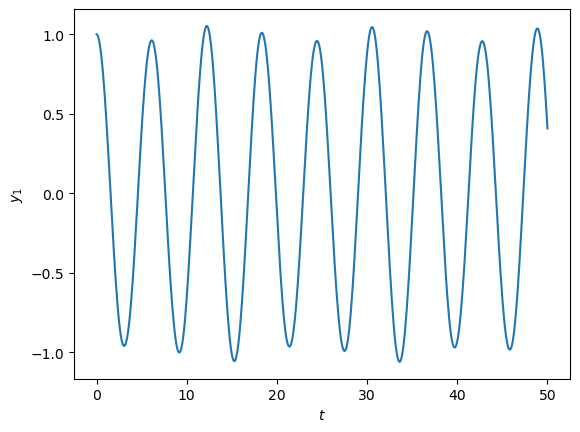

In [6]:
plt.plot(t_range, traj[:, 0])
plt.xlabel("$t$")
plt.ylabel("$y_1$")

Text(0, 0.5, '$y_2$')

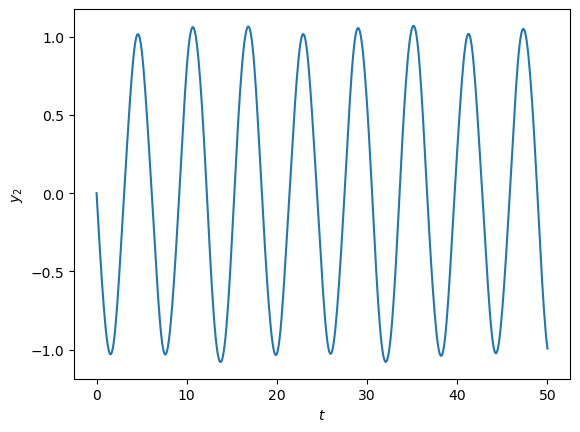

In [7]:
plt.plot(t_range, traj[:, 1])
plt.xlabel("$t$")
plt.ylabel("$y_2$")

## Compute avaraged trajectories for $y_1$ and $y_2$ with sampling multiple initialization for $y_3$ and $y_4$

In [9]:
# Number of initialization 
N = int(1e3)

total_history = np.zeros((num_T + 1, 2, int(N)))
key = jax.random.PRNGKey(1)
for i in tqdm.notebook.tqdm(range(N)):
    key, subkey = jax.random.split(key, 2)
    cur_x0 = jnp.hstack((jnp.array([1, 0]), sigma * jax.random.normal(subkey, (2,))))
    current_traj = spint.odeint(rhs, cur_x0, t_range)
    total_history[:, :, i] = current_traj[:, :2]
    
proj_total_hist = np.mean(total_history, axis=2)

  0%|          | 0/1000 [00:00<?, ?it/s]

Text(0, 0.5, '$y_1$')

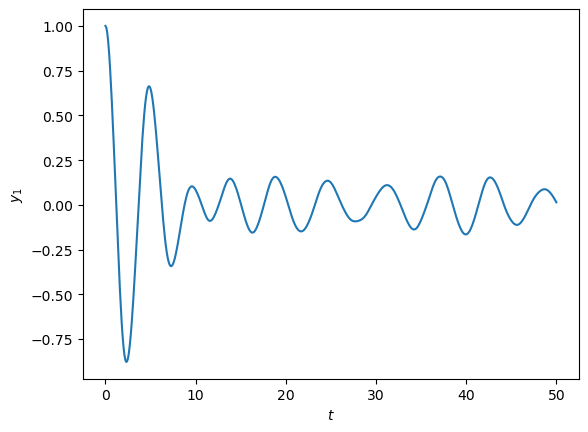

In [10]:
plt.plot(t_range, proj_total_hist[:, 0])
plt.xlabel("$t$")
plt.ylabel("$y_1$")

Text(0, 0.5, '$y_2$')

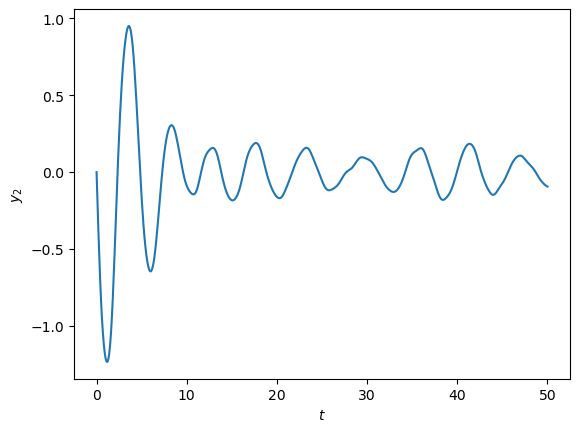

In [11]:
plt.plot(t_range, proj_total_hist[:, 1])
plt.xlabel("$t$")
plt.ylabel("$y_2$")

## Construct linear operator with standard DMD from the generated trajectories for $y_1$ and $y_2$

In [12]:
Gp = traj[1:, :2].T
Gm = traj[:-1, :2].T

def get_vanilla_dmd_model(Gp, Gm):
    return Gp @ jnp.linalg.pinv(Gm)

A_dmd = get_vanilla_dmd_model(Gp, Gm)

In [16]:
# Extract spectrum of A_dmd and resonstruct trajectory from it
eigval_dmd, eigvec_dmd = np.linalg.eig(A_dmd)

def get_prediction(eigval, eigvec, delta_t, x0, t_range):
    omega = jnp.log(eigval) / delta_t
    b = jnp.linalg.solve(eigvec, x0)
    prediction = eigvec @ (jnp.exp(jnp.outer(omega, t_range)) * b[:, None])
    return prediction 
dmd_pred_traj = get_prediction(eigval_dmd, eigvec_dmd, delta_t, x0[:2], t_range)

Text(0, 0.5, '$y_1$')

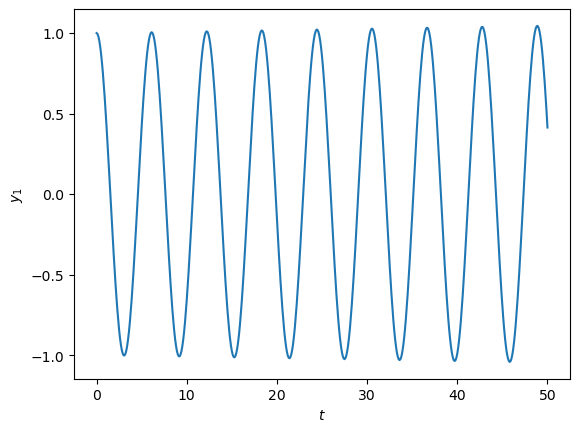

In [19]:
plt.plot(t_range, dmd_pred_traj[0, :].real)
plt.xlabel("$t$")
plt.ylabel("$y_1$")

Text(0, 0.5, '$y_2$')

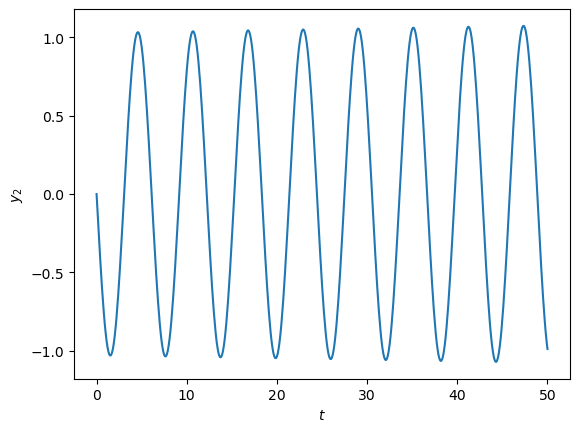

In [20]:
plt.plot(t_range, dmd_pred_traj[1, :].real)
plt.xlabel("$t$")
plt.ylabel("$y_2$")

## Summary

The classical DMD does not show the decay oscillations that are observed after averaging of the rajectories over the hidden parts of states. 

## Implementation of the Mori-Zwanzig representation and solve the corresponding optimization problem to tune result of DMD   

In [25]:
def compute_M(A):
    n = A.shape[0]
    I = jnp.eye(n)
    M = I - 2 * (A - I) @  jnp.linalg.inv(A + I)
    return M

def body_fun(carry, x):
    K0, cur_matrix_exp, matrix_exp, cur_M_power, M, I = carry
    y = cur_matrix_exp @ (cur_M_power - I) @ K0
    y_mean = jnp.mean(y, axis=1)
    carry = (K0, cur_matrix_exp @ matrix_exp, matrix_exp, cur_M_power @ M, M, I)
    return carry, y_mean


def compute_f_scan(A, K0, num_cols, delta_t, num_rows):
    F = jnp.zeros((num_rows, num_cols))
    I = jnp.eye(num_rows)
    M = compute_M(A)
    matrix_exp = jsp.linalg.expm(A - I)
    _, Fpart = jax.lax.scan(body_fun, (K0, matrix_exp, matrix_exp, M, M, I), jnp.arange(1, num_cols))
    F = F.at[:, 1:].set(Fpart.T)
    return F

from functools import partial

@partial(jax.jit, static_argnums=(3, 4))
def compute_M_tilde(A, delta_t, K0, num_cols, num_rows):
    I = jnp.eye(num_rows)
    factor_matrix = jnp.linalg.inv(A - I)
    estimated_snapshots = compute_f_scan(A, K0, num_cols, delta_t, num_rows)
    M_tilde = factor_matrix @ estimated_snapshots
    return M_tilde 

In [26]:
@jax.jit 
def objective(A, Gp, Gm, delta_t, K0):
    # A = jnp.reshape(A_, (2, 2))
    M = compute_M_tilde(A, delta_t, K0, Gp.shape[1], Gp.shape[0])
    residual = Gp - A @ Gm + delta_t**2 * M
    return jnp.sum(residual**2)

In [46]:
import optax
learning_rate = 1e-3
adam_optimizer = optax.adam(learning_rate)
num_internal_adam_iter = 10

def proxy_obj(A, K0):
    return objective(A, Gp, Gm, delta_t, K0)

@jax.jit
def step_optax(params, opt_state, K0):
    loss_value, grads = jax.value_and_grad(proxy_obj)(params, K0)
    updates, opt_state = adam_optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

In [162]:
# Initialization of optimizer
opt_state = adam_optimizer.init(A_dmd)
# Initialization of hidden parts of the dynamics
K0 = sigma * jax.random.normal(jax.random.PRNGKey(11), (2, 1000))

In [163]:
params = A_dmd.copy()
for i in range(num_internal_adam_iter):
    params, opt_state, loss_value = step_optax(params, opt_state, K0)
    print("Iteration = {}, loss = {}".format(i, loss_value))
A_mzdmd = params.copy()
print(jnp.linalg.eigvals(A_mzdmd))

Iteration = 0, loss = 0.06609166655510487
Iteration = 1, loss = 0.01575671928199031
Iteration = 2, loss = 0.015537840908702987
Iteration = 3, loss = 0.020898808784751817
Iteration = 4, loss = 0.027271850307169707
Iteration = 5, loss = 0.03207021754386499
Iteration = 6, loss = 0.033676558845683324
Iteration = 7, loss = 0.03173196338491769
Iteration = 8, loss = 0.027071399973093067
Iteration = 9, loss = 0.02125105172472177
[0.98858489+0.10445446j 0.98858489-0.10445446j]


In [164]:
# Function to generate trajectory for MZDMD approach
def generate_traj_mzdmd(A, t_range, x0, K0):
    n = x0.shape[0]
    I = jnp.eye(n)
    M = I - 2 * (A - I) @ jnp.linalg.inv(A + I)
    traj = np.zeros((x0.shape[0], t_range.shape[0]))
    traj[:, 0] = x0.copy()
    for i in range(1, t_range.shape[0]):
        x_next = A @ traj[:, i-1]
        correction = jnp.mean(jnp.linalg.inv(A - I) @ jsp.linalg.expm((i-1) * (A - I)) @ (jnp.linalg.matrix_power(M, i-1) - I) @ K0, axis=1)
        x_next -= delta_t**2 * correction 
        traj[:, i] = x_next.copy()
    return traj

In [165]:
mz_dmd_traj = generate_traj_mzdmd(A_mzdmd, t_range, x0[:2], np.random.randn(2, 10000))

Text(0, 0.5, '$y_1$')

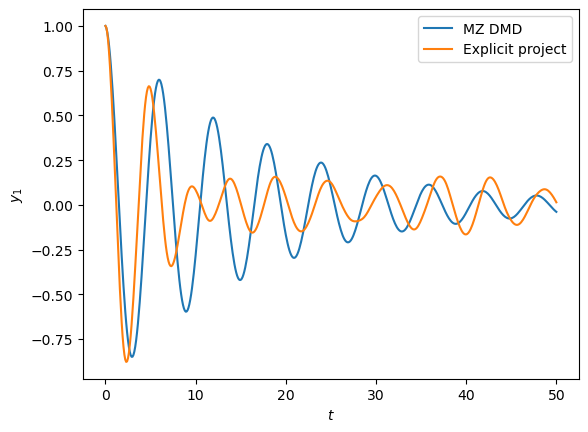

In [166]:
plt.plot(t_range, mz_dmd_traj[0], label="MZ DMD")
plt.plot(t_range, proj_total_hist[:, 0], label="Explicit project")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("$y_1$")

Text(0, 0.5, '$y_1$')

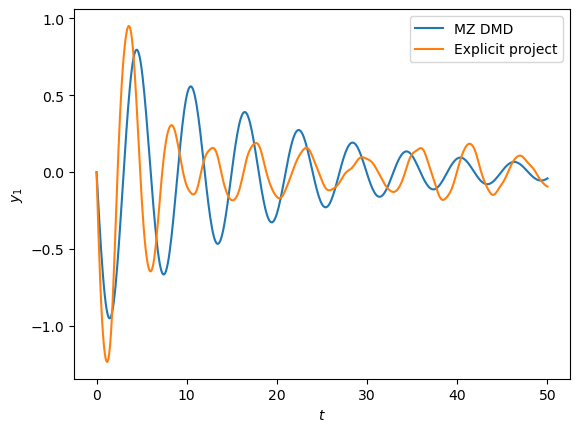

In [167]:
plt.plot(t_range, mz_dmd_traj[1], label="MZ DMD")
plt.plot(t_range, proj_total_hist[:, 1], label="Explicit project")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("$y_1$")

## Summary

MZ DMD approach leads to the linear operator that helps in generating decay oscillations that capture the pattern of the trajectories from explicit projection to the observed space. 

## t-model approximation to simplify optimization problem and  solve it faster 

In [168]:
def body_fun(carry, i):
    delta_t, K0, cur_matrix_exp, matrix_exp = carry
    y = i * delta_t * cur_matrix_exp @ K0
    ymean = jnp.mean(y, axis=1)
    carry = (delta_t, K0, cur_matrix_exp @ matrix_exp, matrix_exp)
    return carry, ymean
    
def compute_M_scan(A, K0, delta_t, num_cols):
    F = jnp.zeros((A.shape[0], num_cols))
    n = A.shape[0]
    I = jnp.eye(n)
    matrix_exp = jsp.linalg.expm(A - I)
    _, Fpart = jax.lax.scan(body_fun, (delta_t, K0, matrix_exp, matrix_exp), jnp.arange(1, num_cols))
    F = F.at[:, 1:].set(Fpart.T)
    return F

@jax.jit
def tmodel_objective(A, Gp, Gm, delta_t, K0):
    M = compute_M_scan(A, K0, delta_t, Gp.shape[1])
    res = Gp - A @ Gm - delta_t * M
    return jnp.sum(jnp.square(res))

In [178]:
learning_rate = 1e-3
adam_optimizer = optax.adam(learning_rate)
num_internal_adam_iter = 10

def proxy_tobj(A, K0):
    return tmodel_objective(A, Gp, Gm, delta_t, K0)

@jax.jit
def step_optax(params, opt_state, K0):
    loss_value, grads = jax.value_and_grad(proxy_tobj)(params, K0)
    updates, opt_state = adam_optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

In [179]:
# Initialization of optimizer
opt_state = adam_optimizer.init(A_dmd)
# Initialization of hidden parts of the dynamics
K0 = sigma * jax.random.normal(jax.random.PRNGKey(1), (2, 1000))

In [180]:
params = A_dmd.copy()
for i in range(num_internal_adam_iter):
    params, opt_state, loss_value = step_optax(params, opt_state, K0)
    print("Iteration = {}, loss = {}".format(i, loss_value))
A_tmzdmd = params.copy()
print(jnp.linalg.eigvals(A_tmzdmd))

Iteration = 0, loss = 0.04986634910689163
Iteration = 1, loss = 0.02493207082748616
Iteration = 2, loss = 0.014503545365525557
Iteration = 3, loss = 0.011182037694369297
Iteration = 4, loss = 0.010374224761292123
Iteration = 5, loss = 0.01055483829232073
Iteration = 6, loss = 0.011279070863203046
Iteration = 7, loss = 0.012307768783118466
Iteration = 8, loss = 0.013429907064571428
Iteration = 9, loss = 0.014439826094696833
[0.98902848+0.10142474j 0.98902848-0.10142474j]


In [181]:
def generate_traj_tmzdmd(A, t_range, x0, K0):
    n = x0.shape[0]
    I = jnp.eye(n)
    traj = np.zeros((x0.shape[0], t_range.shape[0]))
    traj[:, 0] = x0.copy()
    for i in range(1, t_range.shape[0]):
        x_next = A @ traj[:, i-1]
        correction = i * jnp.mean(jsp.linalg.expm(i * (A - I)) @ K0, axis=1)
        x_next += delta_t**2 * correction
        traj[:, i] = x_next.copy()
    return traj

tmz_dmd_traj = generate_traj_tmzdmd(A_tmzdmd, t_range, x0[:2], np.random.randn(2, 10000))


Text(0, 0.5, '$y_1$')

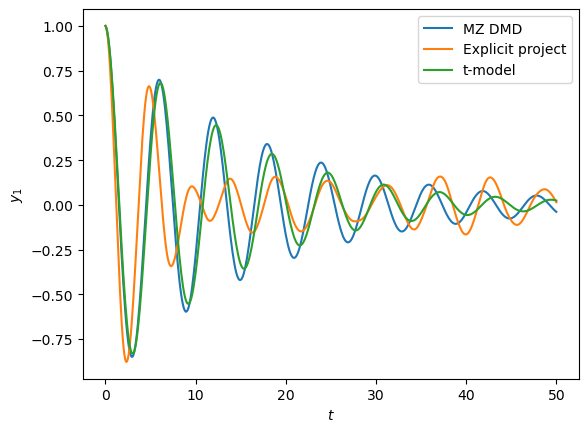

In [182]:
plt.plot(t_range, mz_dmd_traj[0], label="MZ DMD")
plt.plot(t_range, proj_total_hist[:, 0], label="Explicit project")
plt.plot(t_range, tmz_dmd_traj[0], label="t-model")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("$y_1$")

Text(0, 0.5, '$y_2$')

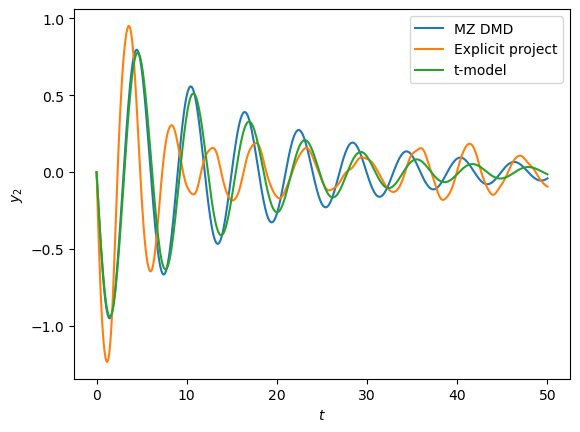

In [183]:
plt.plot(t_range, mz_dmd_traj[1], label="MZ DMD")
plt.plot(t_range, proj_total_hist[:, 1], label="Explicit project")
plt.plot(t_range, tmz_dmd_traj[1], label="t-model")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("$y_2$")

## Summary

The considered t-model provides sufficiently accurate approximation of the exact MZ DMD method although it has significantly lower computational complexity.